# Lab 16: Manual model evaluation and selection

This lab walks through the following for both a regression problem (I) and a classification problem (II):
* split datasets into training, cross validation, and test sets
* evaluate regression and classification models
* add polynomial features to improve the performance of a linear regression model
* compare several neural network architectures

In [2]:
# for array computations and loading data
import numpy as np

# for building linear regression models and preparing data
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# for building and training neural networks
import tensorflow as tf

# custom functions
import lib.utils

# reduce display precision on numpy arrays
np.set_printoptions(precision=2)

# suppress warnings
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(0)

## I. Develop a model for a regression problem

### Load the data

In [5]:
# Load the dataset from the text file
# This dataset consists of 50 examples of an input feature `x` and its corresponding target `y`.
data = np.loadtxt('./data/data_w3_ex1.csv', delimiter=',')

# Split the inputs and outputs into separate arrays
x = data[:,0]
y = data[:,1]

# Convert 1-D arrays into 2-D because the commands later will require it
x = np.expand_dims(x, axis=1)
y = np.expand_dims(y, axis=1)

print(f"the shape of the inputs x is: {x.shape}")
print(f"the shape of the targets y is: {y.shape}")

the shape of the inputs x is: (50, 1)
the shape of the targets y is: (50, 1)


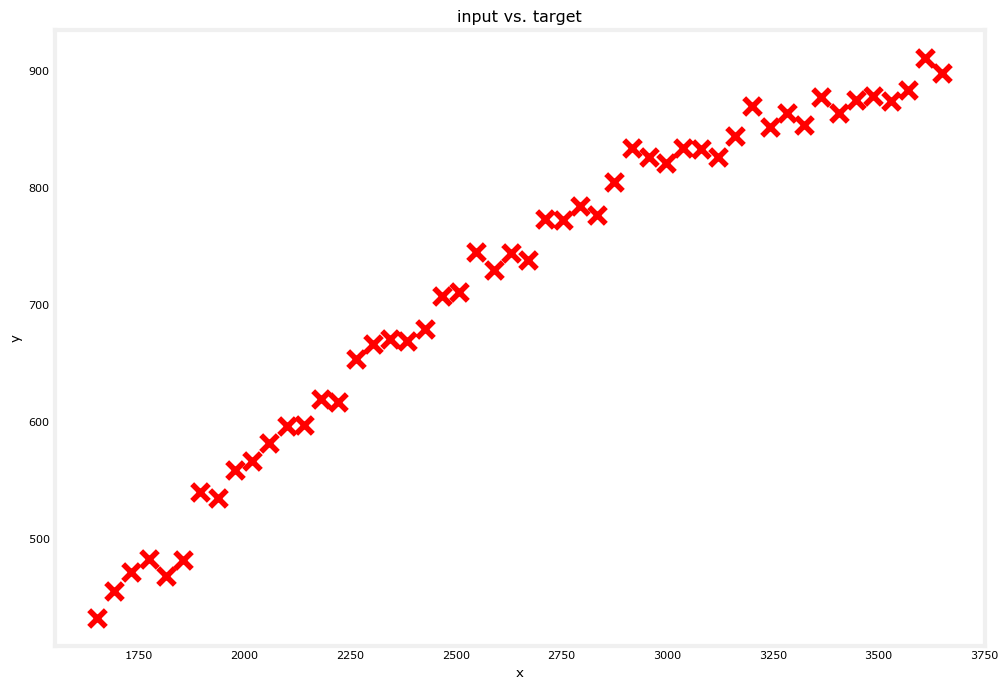

In [7]:
# Plot the entire dataset
lib.utils.plot_dataset(x=x, y=y, title="input vs. target")

### Split the data into 3 sets
* Training set: Use to develop different versions of the model and optimize weights and biases.
* Cross validation set: Use to select the best version.
* Test set: Used to calculate and report the expected loss when the model is used to make predictions on new data. Do not interact with this data while still making decisions about the model. To provide a credible metric, this data should not be allowed to influence training and development.

In [8]:
# Get 60% of the dataset as the training set. Put the remaining 40% in temporary variables: x_ and y_.
x_train, x_, y_train, y_ = train_test_split(x, y, test_size=0.40, random_state=1)

# Split the 40% subset above into two: one half for cross validation and the other for the test set
x_cv, x_test, y_cv, y_test = train_test_split(x_, y_, test_size=0.50, random_state=1)

# Delete temporary variables
del x_, y_

print(f"the shape of the training set (input) is: {x_train.shape}")
print(f"the shape of the training set (target) is: {y_train.shape}\n")
print(f"the shape of the cross validation set (input) is: {x_cv.shape}")
print(f"the shape of the cross validation set (target) is: {y_cv.shape}\n")
print(f"the shape of the test set (input) is: {x_test.shape}")
print(f"the shape of the test set (target) is: {y_test.shape}")

the shape of the training set (input) is: (30, 1)
the shape of the training set (target) is: (30, 1)

the shape of the cross validation set (input) is: (10, 1)
the shape of the cross validation set (target) is: (10, 1)

the shape of the test set (input) is: (10, 1)
the shape of the test set (target) is: (10, 1)


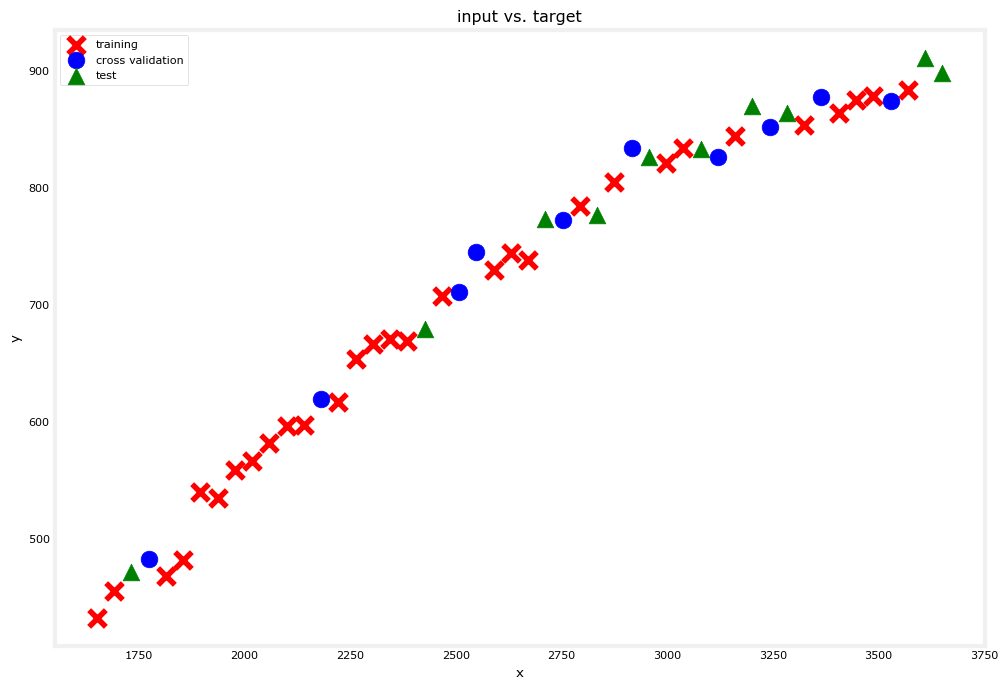

In [10]:
# Plot the three collections of data
lib.utils.plot_train_cv_test(x_train, y_train, x_cv, y_cv, x_test, y_test, title="input vs. target")

### Fit a linear model

#### Feature scaling
Feature scaling (adjusting all inputs so that they have the same range) helps a model converge faster. This is especially true if your input features have widely different ranges of values. 

However, when you start adding polynomial terms of varying degrees (e.g. x^3 and x^5) to a model, the features will indeed have different ranges. For example, if x ranges from 1600 to 3600, then x^2 will range from 2.56 million to 12.96 million.

Computed mean of the training set: 2504.06
Computed standard deviation of the training set: 574.85


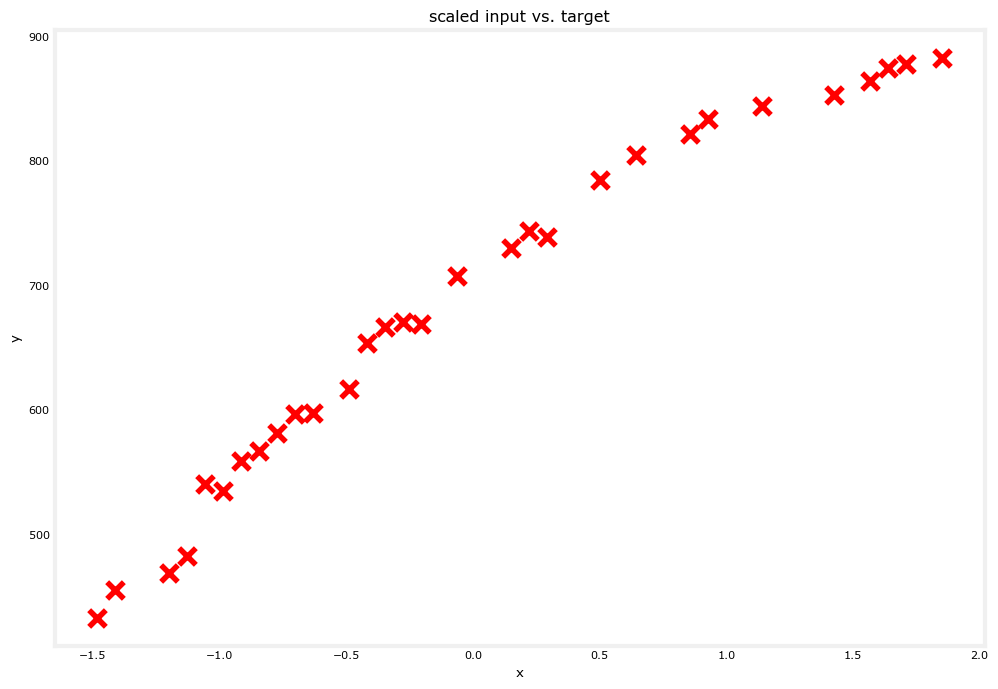

In [12]:
# Feature scale the data 

# StandardScaler class from scikit-learn computes the z-score of the inputs
scaler_linear = StandardScaler()

# Compute the mean and standard deviation of the training set then transform it
X_train_scaled = scaler_linear.fit_transform(x_train)

print(f"Computed mean of the training set: {scaler_linear.mean_.squeeze():.2f}")
print(f"Computed standard deviation of the training set: {scaler_linear.scale_.squeeze():.2f}")

# Plot the results
lib.utils.plot_dataset(x=X_train_scaled, y=y_train, title="scaled input vs. target")

#### Train the linear model

In [13]:
# Initialize the class
linear_model = LinearRegression()

# Train the model
linear_model.fit(X_train_scaled, y_train )

LinearRegression()

### Evaluate the initial linear model

Calculate mean squared error (MSE).

Scikit-learn has a built-in mean_squared_error() function that you can use. NB: scikit-learn's implementation only divides by m and not 2*m, where m is the number of examples. Dividing by 2m is a convention we will follow but the calculations should still work whether or not you include it. Thus, to match the equation above, you can use the scikit-learn function then divide by 2.

Since you trained the model on scaled values (i.e. using the z-score), you should also feed in the scaled training set instead of its raw values.

#### 1) Calculate loss for the optimized model using the original training set (j_train)

In [16]:
# Option 1: Calculate mean squared error using Scikit-learn
# Feed the scaled training set and get the predictions
yhat = linear_model.predict(X_train_scaled)

# Use scikit-learn's utility function and divide by 2
print(f"training MSE (using sklearn function): {mean_squared_error(y_train, yhat) / 2}")


# Option 2: Calculate mean squared error using for-loop
total_squared_error = 0
for i in range(len(yhat)):
    squared_error_i  = (yhat[i] - y_train[i])**2
    total_squared_error += squared_error_i                                              

mse = total_squared_error / (2*len(yhat))

print(f"training MSE (for-loop implementation): {mse.squeeze()}")

training MSE (using sklearn function): 406.19374192533127
training MSE (for-loop implementation): 406.19374192533127


#### 2) Calculate the loss for the optimized model using the cross validation set (j_cv or j_dev)

Don't forget to scale the cross validation set (because we scaled the training set before training the model).

The comparison:
* (from above) Loss / Mean Squared Error (MSE) of training set: 406.19
* (from below) Loss / Mean Squared Error (MSE) of cross validation set: 551.78
* It makes sense that the error on the cross validation set is larger than the error on the training set because the training set was used to optimize the weights and biases.
* Our goal in subsequent parts is to modify the model in an attempt to get a lower loss in the cross validation set.

In [17]:
# Scale the cross validation set using the mean and standard deviation of the training set
# We have to do this because we scaled the training set before training the model.
X_cv_scaled = scaler_linear.transform(x_cv)

print(f"Mean used to scale the CV set: {scaler_linear.mean_.squeeze():.2f}")
print(f"Standard deviation used to scale the CV set: {scaler_linear.scale_.squeeze():.2f}")

# Retrieve the predictions from this model when it is fed the scaled, cross validation set
yhat = linear_model.predict(X_cv_scaled)

# Calculate loss using cross validation set by using scikit-learn's utility function.
# Don't forget to divide by 2.
print(f"Cross validation MSE: {mean_squared_error(y_cv, yhat) / 2}")

Mean used to scale the CV set: 2504.06
Standard deviation used to scale the CV set: 574.85
Cross validation MSE: 551.7789026952216


### Try to improve the model by adding one polynomial feature

Looking at the initial plots of the data, we see that the target y rises more sharply at smaller values of x compared to higher ones. So a straight line might not be the best choice because the target y seems to flatten out as x increases. Now that you have these values of the training and cross validation MSE from the linear model, you can try adding polynomial features to see if you can get a better performance/fit. The code will mostly be the same but with a few extra preprocessing steps.

#### Generate polynomial terms (features) from the original training set

In [20]:
# Instantiate the class to make polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)

# Compute the number of features and transform the training set
X_train_mapped = poly.fit_transform(x_train)

# Preview the first 5 elements of the new training set. Left column is `x` and right column is `x^2`
# Note: The `e+<number>` in the output denotes how many places the decimal point should be moved. For example, `3.24e+03` is equal to `3240`
print(X_train_mapped[:5])

[[3.32e+03 1.11e+07]
 [2.34e+03 5.50e+06]
 [3.49e+03 1.22e+07]
 [2.63e+03 6.92e+06]
 [2.59e+03 6.71e+06]]


#### Scale the inputs to contain the range of numbers

In [21]:
# Instantiate the class
scaler_poly = StandardScaler()

# Compute the mean and standard deviation of the training set. Then transform it.
X_train_mapped_scaled = scaler_poly.fit_transform(X_train_mapped)

# Preview the first 5 elements of the scaled training set.
print(X_train_mapped_scaled[:5])

[[ 1.43  1.47]
 [-0.28 -0.36]
 [ 1.71  1.84]
 [ 0.22  0.11]
 [ 0.15  0.04]]


#### Train the updated polynomial model

In [22]:
# Initialize the class
model = LinearRegression()

# Train the model
model.fit(X_train_mapped_scaled, y_train )

LinearRegression()

#### Evaluate the updated polynomial model

The comparison (from below):
* Loss / Mean Squared Error (MSE) of training set: 49 ...tells us that this updated polynomial model is already better than the linear model (old loss for training set above was 406).
* Loss / Mean Squared Error (MSE) of cross validation set: 87.70 ... tells us that this updated polynomial model is also better on the cross validation set (old loss for the cross validation set on the linear model above was 552).
* It makes sense that the error on the cross validation set is larger than the error on the training set because the training set was used to optimize the weights and biases.
* Our goal in subsequent parts is to modify the model again in an attempt to get a lower loss in the cross validation set.

In [26]:
# 1) LOSS OF TRAINING SET

# Compute the MSE (loss) of the training set
yhat = model.predict(X_train_mapped_scaled)
print(f"Training MSE: {mean_squared_error(y_train, yhat) / 2}")



# 2) LOSS OF CROSS VALIDATION SET

# Add the polynomial features to the cross validation set.
# When we added polynomial features before, we only added them to the training set.
X_cv_mapped = poly.transform(x_cv)

# Scale the cross validation set using the mean and standard deviation of the training set
X_cv_mapped_scaled = scaler_poly.transform(X_cv_mapped)

# Compute the cross validation MSE
yhat = model.predict(X_cv_mapped_scaled)
print(f"Cross validation MSE: {mean_squared_error(y_cv, yhat) / 2}")

Training MSE: 49.111609334025175
Cross validation MSE: 87.69841211111921


### Try to improve the model AGAIN by adding higher degree polynomial feature

We will use a loop where each iteration adds one more degree higher of polynomial.

In [31]:
# Initialize lists to save the errors, models, and feature transforms so they can be plotted later
train_mses = []
cv_mses = []
models = []
polys = []
scalers = []

# Loop over 10 times. Each adding one more degree of polynomial higher than the last.
for degree in range(1,11):
    
    # Add polynomial features to the training set
    poly = PolynomialFeatures(degree, include_bias=False)
    X_train_mapped = poly.fit_transform(x_train)
    polys.append(poly)
    
    # Scale the training set
    scaler_poly = StandardScaler()
    X_train_mapped_scaled = scaler_poly.fit_transform(X_train_mapped)
    scalers.append(scaler_poly)
    
    # Create and train the model
    model = LinearRegression()
    model.fit(X_train_mapped_scaled, y_train )
    models.append(model)
    
    # Compute the training MSE
    yhat = model.predict(X_train_mapped_scaled)
    train_mse = mean_squared_error(y_train, yhat) / 2
    train_mses.append(train_mse)
    
    # Add polynomial features and scale the cross validation set
    X_cv_mapped = poly.transform(x_cv)
    X_cv_mapped_scaled = scaler_poly.transform(X_cv_mapped)
    
    # Compute the cross validation MSE
    yhat = model.predict(X_cv_mapped_scaled)
    cv_mse = mean_squared_error(y_cv, yhat) / 2
    cv_mses.append(cv_mse)

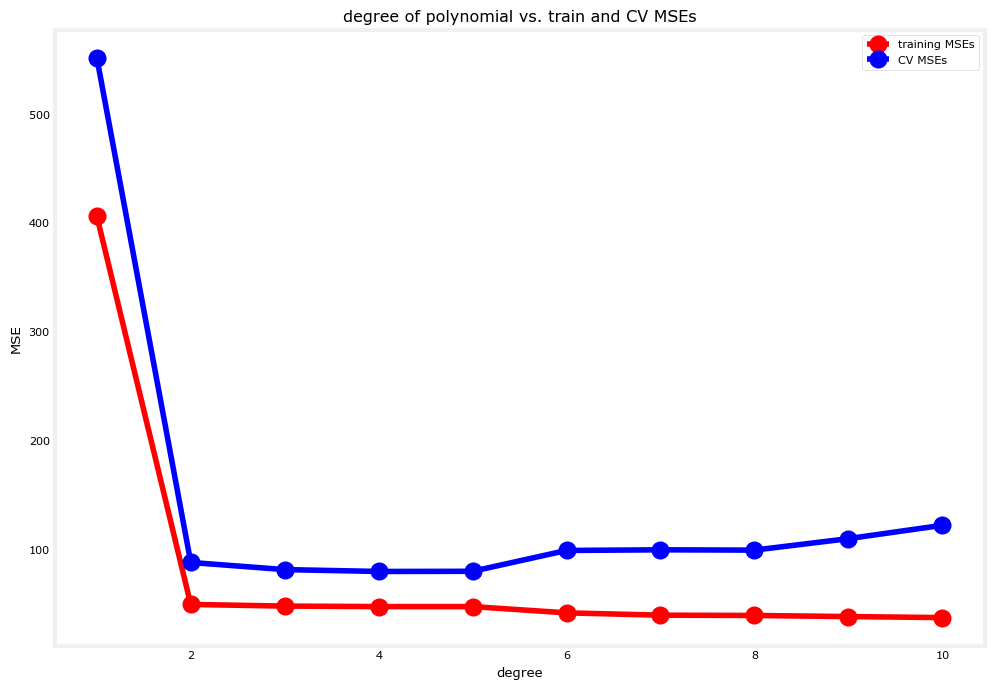

In [34]:
# Plot the results
# The x-axis are the degress of polynomials representing the 10 models generated and trained in the loops above
# The y-axis is the loss (red = loss of training set; blue = loss of cross validation set)

degrees=range(1,11)
lib.utils.plot_train_cv_mses(degrees, train_mses, cv_mses, title="degree of polynomial vs. train and CV MSEs")

### Choose the best model

We can see from the above plot that moving from 1st degree polynomial (linear) to 2nd degree polynomial (quadratic) improves the model a lot. The loss drops dramatically.

Moving from 2nd degree polynomial to higher degree polynomials has minimal impact. As we go to higher and higher level polynomials, over-fitting is likely occurring because the loss for the training set gets slightly lower but the loss for the cross validation set starts to increase.

In [36]:
# Select the model with the lowest loss in the cross validation set (CV MSE).
# Don't forget to add 1 because list indices start at 0 but the degrees of polynomials are numbered starting at 1.
degree = np.argmin(cv_mses) + 1
print(f"Lowest CV MSE is found in the model with degree: {degree}")

Lowest CV MSE is found in the model with degree: 4


### Publish the expected loss by using the selected model on the test set

The test set has not yet been used up to this point so it is appropriate for understanding the expected performance of the model given completely new data.

The outcome (below) is a test loss (mean squared error) 104.63. This is higher than the trained set loss and the cross validation set loss, which is expected because those other data sets influenced the decision-making... the model was optimized with their influence. 

In [38]:
# Add polynomial features to the test set
X_test_mapped = polys[degree-1].transform(x_test)

# Scale the test set
X_test_mapped_scaled = scalers[degree-1].transform(X_test_mapped)

# Compute the test MSE
yhat = models[degree-1].predict(X_test_mapped_scaled)
test_mse = mean_squared_error(y_test, yhat) / 2

print(f"Training MSE: {train_mses[degree-1]:.2f}")
print(f"Cross Validation MSE: {cv_mses[degree-1]:.2f}")
print(f"Test MSE: {test_mse:.2f}")

Training MSE: 47.15
Cross Validation MSE: 79.43
Test MSE: 104.63


## Optimizing a model by changing the neural network architecture

* This section uses the training, cross validation, and test datasets that were developed in the previous sections.
* The different architectures are built using the utils library.
* Though we do not explicity develop multiple degree polynomial functions in this section, remember that neural networks can learn polynomial (non-linear) relationships. So the functions developed below are not necessarily linear.

### Prepare the data

In [40]:
# Add polynomial features
degree = 1
poly = PolynomialFeatures(degree, include_bias=False)
X_train_mapped = poly.fit_transform(x_train)
X_cv_mapped = poly.transform(x_cv)
X_test_mapped = poly.transform(x_test)

In [41]:
# Scale the features using the z-score
scaler = StandardScaler()
X_train_mapped_scaled = scaler.fit_transform(X_train_mapped)
X_cv_mapped_scaled = scaler.transform(X_cv_mapped)
X_test_mapped_scaled = scaler.transform(X_test_mapped)

### Build 3 different models (uses a library)

In [43]:
nn_models = lib.utils.build_models()

### Train the 3 models and calculate the cross validation loss for each
* Loops over the 3 models generated above (stored in nn_models variable).
* For each model, it compiles and trains/fits the model using the training set.
* For each model, it calculates the loss using the cross validation set.

In [46]:
# Initialize lists that will contain the errors for each model
nn_train_mses = []
nn_cv_mses = []

# Loop over the the models
for model in nn_models:
    
    # Setup the loss and optimizer
    model.compile(
    loss='mse',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    )

    print(f"Training {model.name}...")
    
    # Train the model
    model.fit(
        X_train_mapped_scaled, y_train,
        epochs=300,
        verbose=0
    )
    
    print("Done!\n")

    
    # Record the training MSEs
    yhat = model.predict(X_train_mapped_scaled)
    train_mse = mean_squared_error(y_train, yhat) / 2
    nn_train_mses.append(train_mse)
    
    # Record the cross validation MSEs 
    yhat = model.predict(X_cv_mapped_scaled)
    cv_mse = mean_squared_error(y_cv, yhat) / 2
    nn_cv_mses.append(cv_mse)

    
# print results
print("RESULTS:")
for model_num in range(len(nn_train_mses)):
    print(
        f"Model {model_num+1}: Training MSE: {nn_train_mses[model_num]:.2f}, " +
        f"CV MSE: {nn_cv_mses[model_num]:.2f}"
        )

Training model_1...
Done!

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Training model_2...
Done!

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Training model_3...
Done!

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
RESULTS:
Model 1: Training MSE: 46.82, CV MSE: 83.87
Model 2: Training MSE: 70.74, CV MSE: 115.38
Model 3: Training MSE: 47.21, CV MSE: 84.05


### Select the model with the lowest loss on the cross validation set; Report the performance using the test set

In [47]:
# Select the model with the lowest CV MSE (loss on the cross validation set)
# In the course material, model 3 has the lowest CV MSE and that is hard-coded here.
model_num = 3

# Compute the test MSE (against model 3)
yhat = nn_models[model_num-1].predict(X_test_mapped_scaled)
test_mse = mean_squared_error(y_test, yhat) / 2

print(f"Selected Model: {model_num}")
print(f"Training MSE: {nn_train_mses[model_num-1]:.2f}")
print(f"Cross Validation MSE: {nn_cv_mses[model_num-1]:.2f}")
print(f"Test MSE: {test_mse:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Selected Model: 3
Training MSE: 47.21
Cross Validation MSE: 84.05
Test MSE: 98.48


## II. Develop a model for a classification problem

### Load the data

In [48]:
# Load the dataset from a text file
data = np.loadtxt('./data/data_w3_ex2.csv', delimiter=',')

# Split the inputs and outputs into separate arrays
x_bc = data[:,:-1]
y_bc = data[:,-1]

# Convert y into 2-D because the commands later will require it (x is already 2-D)
y_bc = np.expand_dims(y_bc, axis=1)

print(f"the shape of the inputs x is: {x_bc.shape}")
print(f"the shape of the targets y is: {y_bc.shape}")

the shape of the inputs x is: (200, 2)
the shape of the targets y is: (200, 1)


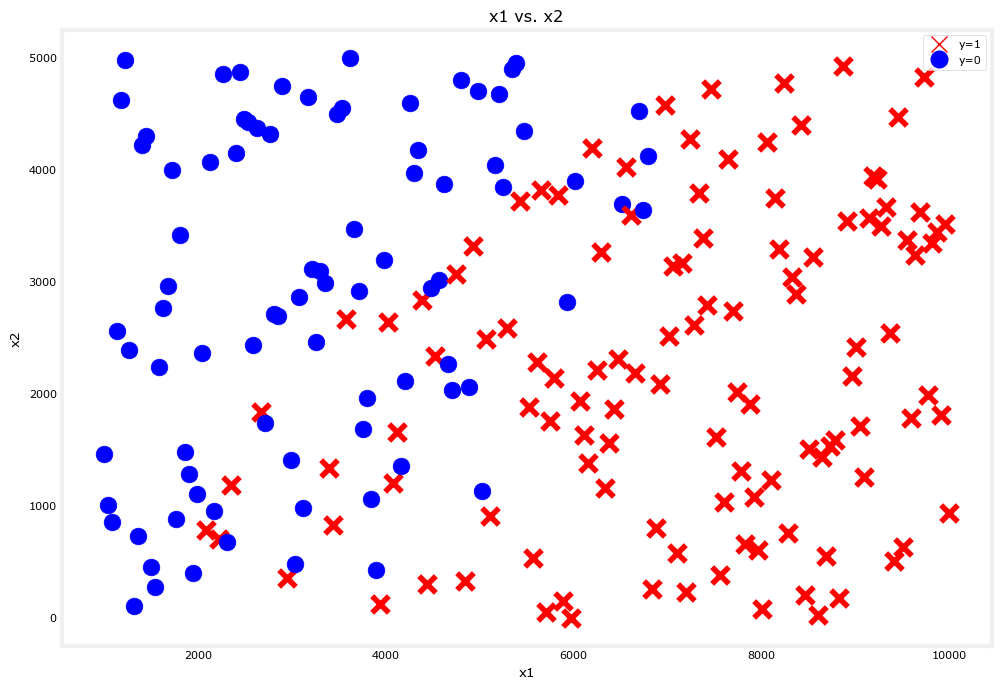

In [49]:
# plot the dataset
lib.utils.plot_bc_dataset(x=x_bc, y=y_bc, title="x1 vs. x2")

### Split the original dataset into subsets for: training, cross validation, and test

In [50]:
from sklearn.model_selection import train_test_split

# Get 60% of the dataset as the training set. Put the remaining 40% in temporary variables.
x_bc_train, x_, y_bc_train, y_ = train_test_split(x_bc, y_bc, test_size=0.40, random_state=1)

# Split the 40% subset above into two: one half for cross validation and the other for the test set
x_bc_cv, x_bc_test, y_bc_cv, y_bc_test = train_test_split(x_, y_, test_size=0.50, random_state=1)

# Delete temporary variables
del x_, y_

print(f"the shape of the training set (input) is: {x_bc_train.shape}")
print(f"the shape of the training set (target) is: {y_bc_train.shape}\n")
print(f"the shape of the cross validation set (input) is: {x_bc_cv.shape}")
print(f"the shape of the cross validation set (target) is: {y_bc_cv.shape}\n")
print(f"the shape of the test set (input) is: {x_bc_test.shape}")
print(f"the shape of the test set (target) is: {y_bc_test.shape}")

the shape of the training set (input) is: (120, 2)
the shape of the training set (target) is: (120, 1)

the shape of the cross validation set (input) is: (40, 2)
the shape of the cross validation set (target) is: (40, 1)

the shape of the test set (input) is: (40, 2)
the shape of the test set (target) is: (40, 1)


### Scale all of the datasets

In [51]:
# Scale the features

# Initialize the class
scaler_linear = StandardScaler()

# Compute the mean and standard deviation of the training set then transform it
x_bc_train_scaled = scaler_linear.fit_transform(x_bc_train)
x_bc_cv_scaled = scaler_linear.transform(x_bc_cv)
x_bc_test_scaled = scaler_linear.transform(x_bc_test)

### Calculate loss
* In regression problems (previous section), calculate loss as the mean squared error.
* In classification problems (this section), calculate loss as the fraction of examples for which the prediction is the same as the labelled output.

In [52]:
# Sample model output
probabilities = np.array([0.2, 0.6, 0.7, 0.3, 0.8])

# Apply a threshold to the model output. If greater than 0.5, set to 1. Else 0.
predictions = np.where(probabilities >= 0.5, 1, 0)

# Ground truth labels
ground_truth = np.array([1, 1, 1, 1, 1])

# Initialize counter for misclassified data
misclassified = 0

# Get number of predictions
num_predictions = len(predictions)

# Loop over each prediction
for i in range(num_predictions):
    
    # Check if it matches the ground truth
    if predictions[i] != ground_truth[i]:
        
        # Add one to the counter if the prediction is wrong
        misclassified += 1

# Compute the fraction of the data that the model misclassified
fraction_error = misclassified/num_predictions

print(f"probabilities: {probabilities}")
print(f"predictions with threshold=0.5: {predictions}")
print(f"targets: {ground_truth}")
print(f"fraction of misclassified data (for-loop): {fraction_error}")
print(f"fraction of misclassified data (with np.mean()): {np.mean(predictions != ground_truth)}")

probabilities: [0.2 0.6 0.7 0.3 0.8]
predictions with threshold=0.5: [0 1 1 0 1]
targets: [1 1 1 1 1]
fraction of misclassified data (for-loop): 0.4
fraction of misclassified data (with np.mean()): 0.4


### Build multiple models to choose from (using a library)

In [54]:
models_bc = lib.utils.build_models()

### Train the models and make predictions using all the subsets of data

If there is a tie on the loss on the cross validation set (between one or more models), then you can add another criteria to break it. For example, you can choose the one with a lower training error. A more common approach is to choose the smaller model because it saves computational resources. In our example, Model 1 is the smallest and Model 3 is the largest.

In [55]:
# Initialize lists that will contain the errors for each model
nn_train_error = []
nn_cv_error = []

# Loop over each model
for model in models_bc:
    
    # Setup the loss and optimizer
    model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    )

    print(f"Training {model.name}...")

    # Train the model
    model.fit(
        x_bc_train_scaled, y_bc_train,
        epochs=200,
        verbose=0
    )
    
    print("Done!\n")
    
    # Set the threshold for classification
    threshold = 0.5
    
    # Record the fraction of misclassified examples for the training set
    yhat = model.predict(x_bc_train_scaled)
    yhat = tf.math.sigmoid(yhat)
    yhat = np.where(yhat >= threshold, 1, 0)
    train_error = np.mean(yhat != y_bc_train)
    nn_train_error.append(train_error)

    # Record the fraction of misclassified examples for the cross validation set
    yhat = model.predict(x_bc_cv_scaled)
    yhat = tf.math.sigmoid(yhat)
    yhat = np.where(yhat >= threshold, 1, 0)
    cv_error = np.mean(yhat != y_bc_cv)
    nn_cv_error.append(cv_error)

# Print the result
for model_num in range(len(nn_train_error)):
    print(
        f"Model {model_num+1}: Training Set Classification Error: {nn_train_error[model_num]:.5f}, " +
        f"CV Set Classification Error: {nn_cv_error[model_num]:.5f}"
        )

Training model_1...
Done!

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Training model_2...
Done!

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Training model_3...
Done!

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Model 1: Training Set Classification Error: 0.05000, CV Set Classification Error: 0.15000
Model 2: Training Set Classification Error: 0.08333, CV Set Classification Error: 0.15000
Model 3: Training Set Classification Error: 0.41667, CV Set Classification Error: 0.47500


### Report the loss expected with future, new data sets (by using the test dataset)

In [56]:
# Select the model with the lowest error (in the course notebook); this is hard-coded
model_num = 3

# Compute the test error
yhat = models_bc[model_num-1].predict(x_bc_test_scaled)
yhat = tf.math.sigmoid(yhat)
yhat = np.where(yhat >= threshold, 1, 0)
nn_test_error = np.mean(yhat != y_bc_test)

print(f"Selected Model: {model_num}")
print(f"Training Set Classification Error: {nn_train_error[model_num-1]:.4f}")
print(f"CV Set Classification Error: {nn_cv_error[model_num-1]:.4f}")
print(f"Test Set Classification Error: {nn_test_error:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Selected Model: 3
Training Set Classification Error: 0.4167
CV Set Classification Error: 0.4750
Test Set Classification Error: 0.3750
